In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [25]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [26]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")


Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2060


In [27]:
# show first image
import matplotlib.pyplot as plt


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.cpu().numpy().transpose((1, 2, 0))


    ax.set_title(title)
    ax.imshow(image, cmap='binary')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def from_one_hot(one_hot):
    # one hot is 30 long
    # first 10 are first digit, second 10 are second digit, third 10 are third digit
    # each 10 is one-hot encoding of digit
    # so we just need to find the index of the max value in each 10
    # and then convert to string
    digits = []

    hots = torch.split(one_hot, 10)
    for hot in hots:
        digits.append(str(hot.argmax().item()))

    return int("".join([str(x) for x in digits]))


In [38]:
# load image dataset
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# import Image
from PIL import Image


def target_transform(target):
    # print("got target ", target)

    # apply one-hot encoding
    one_hot = torch.zeros(30, device=device)

    # target is 3 digit number
    target = str(target)
    if len(target) < 3:
        target = "0" * (3 - len(target)) + target

    # print("transformed target ", target)

    digits = [int(x) for x in str(target)]
    for i, digit in enumerate(digits):
        one_hot[i*10 + digit] = 1

    # print("one hot ", one_hot)

    return one_hot


def image_transform(image):
    # create image tensor from PIL image
    image = transforms.ToTensor()(image)

    return image.to(device)


class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform

        self.images = []
        self.targets = []

        for numberdir in os.listdir(root):
            for image in os.listdir(os.path.join(root, numberdir)):
                imagepath = os.path.join(numberdir, image)

                img = Image.open(os.path.join(root, imagepath))
                if self.transform is not None:
                    img = self.transform(img)

                self.images.append(img)
                # self.images.append(os.path.join(numberdir, image))

                ndir = int(numberdir)
                if self.target_transform is not None:
                    ndir = self.target_transform(ndir)

                self.targets.append(ndir)

    def __getitem__(self, index):
        image = self.images[index]
        target = self.targets[index]

        # image = Image.open(os.path.join(self.root, image))
        # if self.transform is not None:
        #     image = self.transform(image)

        return image, target

    def __len__(self):
        return len(self.images)


train_ds = CustomImageFolder(root='triple_mnist/train',
                             transform=image_transform,
                             target_transform=target_transform)


In [39]:
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

# preload batches to gpu
for i, (images, targets) in enumerate(dataloader):
    if i == 0:
        print("preloading batches to gpu")
    images = images.to(device)
    targets = targets.to(device)


preloading batches to gpu


<AxesSubplot: title={'center': "tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\n        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')"}>

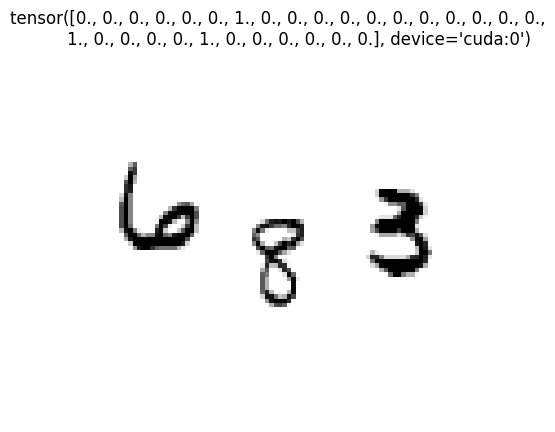

In [40]:

# Get one batch
images, labels = next(iter(dataloader))

imshow(images[0], title=labels[0])


In [41]:
# define model

import time


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(84*84, 256)
        # Write 2 lines to define 2 more linear layers.
        # 1 hidden layers with number of neurons numbers: 250 and 100
        # 1 output layer that should output 10 neurons, one for each class.
        self.hidden2 = nn.Linear(256, 100)
        self.output = nn.Linear(100, 30)

    def forward(self, x):
        # the linear layers fc1, fc2, fc3, and fc4
        # accepts only flattened input (1D batches)
        # while the batch x is of size (batch, 28 * 28)
        # define one line to flatten the x to be of size (batch_sz, 28 * 28)
        x = x.view(-1, 84*84)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return F.log_softmax(x, dim=1)


cnn = Net().to(device)

# define loss function
criterion = nn.BCEWithLogitsLoss().to(device)

# define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)


# train model
epochs = 8
for e in range(epochs):
    time_start = time.time()
    running_loss = 0
    for images, labels in dataloader:
        # Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = cnn(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e,
              running_loss / len(dataloader)))
        # print time spent for epoch
        print("Time spent for epoch: ", time.time() - time_start)


Epoch 0 - Training loss: 0.3030607995390892
Time spent for epoch:  2.2549636363983154
Epoch 1 - Training loss: 0.23574922509491444
Time spent for epoch:  2.051508903503418
Epoch 2 - Training loss: 0.20667118401825427
Time spent for epoch:  2.07045841217041
Epoch 3 - Training loss: 0.19110746946930884
Time spent for epoch:  2.069460153579712
Epoch 4 - Training loss: 0.18042877389490605
Time spent for epoch:  2.0963897705078125
Epoch 5 - Training loss: 0.17260856345295905
Time spent for epoch:  2.0764424800872803
Epoch 6 - Training loss: 0.16670316830277443
Time spent for epoch:  2.095419406890869
Epoch 7 - Training loss: 0.16221085153520107
Time spent for epoch:  2.104339122772217


In [42]:
def from_ps(ps):
    # one hot is 30 long
    # first 10 are first digit, second 10 are second digit, third 10 are third digit
    # each 10 is one-hot encoding of digit
    # so we just need to find the index of the max value in each 10
    # and then convert to string
    digits = []
    # ps = ps.numpy()

    hots = torch.split(ps, 10)
    for hot in hots:
        digits.append(str(hot.argmax().item()))

    return int("".join([str(x) for x in digits]))

In [43]:
# validate model

# load test dataset
test_ds = CustomImageFolder(root='triple_mnist/test',
                            transform=image_transform,
                            target_transform=target_transform)


In [44]:

testloader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        # images = images.view(images.shape[0], -1)
        outputs = cnn(images)

        # get predictions
        ps = F.softmax(outputs, dim=1)
        for i, ps in enumerate(ps):
            pred = from_ps(ps)
            actual = from_one_hot(labels[i])

            if pred == actual:
                correct += 1
            total += 1


In [45]:
print(correct / total)

0.5173


In [ ]:
# save model
# torch.save(cnn.state_dict(), 'triple_mnist_ann_53.pth')

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.hidden1 = nn.Linear(84*84, 256)
#         # Write 2 lines to define 2 more linear layers.
#         # 1 hidden layers with number of neurons numbers: 250 and 100
#         # 1 output layer that should output 10 neurons, one for each class.
#         self.hidden2 = nn.Linear(256, 100)
#         self.output = nn.Linear(100, 30)

#     def forward(self, x):
#         # the linear layers fc1, fc2, fc3, and fc4
#         # accepts only flattened input (1D batches)
#         # while the batch x is of size (batch, 28 * 28)
#         # define one line to flatten the x to be of size (batch_sz, 28 * 28)
#         x = x.view(-1, 84*84)
#         x = F.relu(self.hidden1(x))
#         x = F.relu(self.hidden2(x))
#         x = self.output(x)
#         return F.log_softmax(x, dim=1)


In [50]:
# define CNN model
# input 84x84
# output 30

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(128 * 5 * 5, 256)

        self.fc2 = nn.Linear(256, 100)

        self.fc3 = nn.Linear(100, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)



cnn = CNN().to(device)

# define loss function
criterion = nn.BCEWithLogitsLoss().to(device)

# define optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)

# train model
epochs = 10
for e in range(epochs):
    time_start = time.time()
    running_loss = 0
    for images, labels in dataloader:
        # Flatten MNIST images into a 784 long vector
        # images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = cnn(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e,
              running_loss / len(dataloader)))
        # print time spent for epoch
        print("Time spent for epoch: ", time.time() - time_start)


Epoch 0 - Training loss: 0.22911117224395275
Time spent for epoch:  10.778152227401733
Epoch 1 - Training loss: 0.1571738863289356
Time spent for epoch:  8.586018085479736
Epoch 2 - Training loss: 0.14863955402374268
Time spent for epoch:  8.593998193740845
Epoch 3 - Training loss: 0.14519672967493535
Time spent for epoch:  8.632893800735474
Epoch 4 - Training loss: 0.14330504210293293
Time spent for epoch:  8.62691068649292
Epoch 5 - Training loss: 0.1420616999566555
Time spent for epoch:  8.601975917816162
Epoch 6 - Training loss: 0.14119232438504695
Time spent for epoch:  8.609955310821533
Epoch 7 - Training loss: 0.14072730828821658
Time spent for epoch:  8.625913143157959
Epoch 8 - Training loss: 0.140227740123868
Time spent for epoch:  8.606963396072388
Epoch 9 - Training loss: 0.14015968637168408
Time spent for epoch:  8.617933988571167


In [51]:
# validate on test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        # images = images.view(images.shape[0], -1)
        outputs = cnn(images)

        # get predictions
        # ps = F.softmax(outputs, dim=1)
        ps = outputs
        for i, ps in enumerate(ps):
            pred = int(from_ps(ps))
            actual = int(from_one_hot(labels[i]))

            if pred == actual:
                correct += 1
            total += 1

print(correct / total)

0.9701


In [ ]:
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )
        self.out = nn.Linear(16 * 42 * 42, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
"""
# save current cnn model
# torch.save(cnn.state_dict(), 'triple_mnist_cnn.pth')

In [ ]:
"""
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(128 * 5 * 5, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output
"""
# torch.save(cnn.state_dict(), 'triple_mnist_cnn_best.pth')
